In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import scipy
from scipy import stats
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import sklearn
from sklearn.model_selection import KFold
from matplotlib import rcParams
import joblib
import cartopy.crs as ccrs
from sklearn.metrics import r2_score
import glob
import warnings
warnings.filterwarnings('ignore')

In [4]:
### load ERA5 temperature data
nt_train=444
la=6
lb=30
era_ta = netCDF4.Dataset('./data/cmip/ta/ta_ERA5_1984_01_2020_12.nc')['t'][:nt_train,1:-1,la:lb,:]
era_level = netCDF4.Dataset('./data/cmip/ta/ta_ERA5_1984_01_2020_12.nc')['level'][1:-1]
era_lat = netCDF4.Dataset('./data/cmip/ta/ta_ERA5_1984_01_2020_12.nc')['lat'][la:lb]
era_lon = netCDF4.Dataset('./data/cmip/ta/ta_ERA5_1984_01_2020_12.nc')['lon'][:]
cmip_level = netCDF4.Dataset('./data/cmip/ta/ta_Amon_ACCESS1-0_historical-rcp45_r1i1p1.nc')['plev'][1:-1]
cmip_lat = netCDF4.Dataset('./data/cmip/ta/ta_Amon_ACCESS1-0_historical-rcp45_r1i1p1.nc')['lat'][la:lb]
cmip_lon = netCDF4.Dataset('./data/cmip/ta/ta_Amon_ACCESS1-0_historical-rcp45_r1i1p1.nc')['lon'][:]
swoosh_tropics_Will = netCDF4.Dataset('./data/swoosh/SWOOSH_samples_scaleSE_1.0_scaleB_1.0_nsamples_50_aura5_finalNatGeo.nc')['samples'][:,:]
swoosh_tropics_Will_mean = np.mean(swoosh_tropics_Will,axis=1)
### note the non-nan indices start at 72 - i.e. at 01/1990!
non_nan_indices = np.argwhere(~np.isnan(swoosh_tropics_Will[:,0])).T
### calculate SWOOSH seasonal cycle from filled dataset:
fn = './data/swoosh/swoosh-v02.7-198401-202202-latpress-10deg-L31.nc'
data_swoosh_filled = netCDF4.Dataset(fn)
latitude_swoosh = np.array(data_swoosh_filled['lat'][:])
### take seasonal cycle from 01/1990 onwards
initial_idx = 72
h2of = np.array(data_swoosh_filled['combinedanomfillh2oq'][:nt_train])    #h2o filled
time_swoosh = np.array(data_swoosh_filled['time'][:nt_train])                    #time index
### level 8 is 68 hPa
plev = 8
h2of = h2of[:,plev,:]
weights_swoosh = np.cos(latitude_swoosh*np.pi/180.0)
h2of_weighted_30N_30S = np.sum(h2of[:,6:12]*weights_swoosh[6:12],axis=1)/np.sum(weights_swoosh[6:12])
### calculate seasonal cycle starting in January 1990
h2of_seasonal_cycle = np.empty((12))
swoosh_anomalies = np.empty((nt_train))
for i in range(0,12):
    h2of_seasonal_cycle[i] = np.mean(h2of_weighted_30N_30S[i+initial_idx::12])
    swoosh_anomalies[i::12] = h2of_weighted_30N_30S[i::12] - h2of_seasonal_cycle[i]
swoosh_anomalies = swoosh_anomalies[non_nan_indices[0,:]]
time_swoosh_anomalies = time_swoosh[non_nan_indices[0,:]]

In [5]:
### load MERRA2 for temperature
merra_ta = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_MERRA2_198401-201912_5x5_7levels.nc')['ta'][:nt_train,1:-1,la:lb,:]
merra_level = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_MERRA2_198401-201912_5x5_7levels.nc')['plev'][1:-1]/100.0
merra_lat = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_MERRA2_198401-201912_5x5_7levels.nc')['lat'][la:lb]
merra_lon = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_MERRA2_198401-201912_5x5_7levels.nc')['lon'][:]

In [7]:
### load JRA-55 for temperature
jra_ta = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_JRA-55_198401-202012_5x5_7levels.nc')['ta'][:nt_train,1:-1,la:lb,:]
jra_level = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_JRA-55_198401-202012_5x5_7levels.nc')['plev'][1:-1]/100.0
jra_lat = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_JRA-55_198401-202012_5x5_7levels.nc')['lat'][la:lb]
jra_lon = netCDF4.Dataset('./data/cmip/ta/ta_Amon_reanalysis_JRA-55_198401-202012_5x5_7levels.nc')['lon'][:]

In [8]:
merra_level

masked_array(data=[250.0, 200.0, 150.0, 100.0, 70.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [9]:
jra_level

masked_array(data=[250.0, 200.0, 150.0, 100.0, 70.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [10]:
merra_ta.shape

(432, 5, 24, 72)

In [11]:
jra_ta.shape

(444, 5, 24, 72)

In [12]:
### flip vertical axis for ERA5 to match CMIP models
era_ta = np.flip(era_ta,axis=1)

In [13]:
era_ta.shape

(444, 5, 24, 72)

In [14]:
np.flip(era_level)

masked_array(data=[250., 200., 150., 100.,  70.],
             mask=False,
       fill_value=1e+20)

In [15]:
cmip_level

masked_array(data=[25000., 20000., 15000., 10000.,  7000.],
             mask=False,
       fill_value=1e+20)

In [16]:
era_lat

masked_array(data=[-57.5, -52.5, -47.5, -42.5, -37.5, -32.5, -27.5, -22.5,
                   -17.5, -12.5,  -7.5,  -2.5,   2.5,   7.5,  12.5,  17.5,
                    22.5,  27.5,  32.5,  37.5,  42.5,  47.5,  52.5,  57.5],
             mask=False,
       fill_value=1e+20)

In [17]:
cmip_lat

masked_array(data=[-57.5, -52.5, -47.5, -42.5, -37.5, -32.5, -27.5, -22.5,
                   -17.5, -12.5,  -7.5,  -2.5,   2.5,   7.5,  12.5,  17.5,
                    22.5,  27.5,  32.5,  37.5,  42.5,  47.5,  52.5,  57.5],
             mask=False,
       fill_value=1e+20)

In [18]:
era_lon

masked_array(data=[-177.5, -172.5, -167.5, -162.5, -157.5, -152.5, -147.5,
                   -142.5, -137.5, -132.5, -127.5, -122.5, -117.5, -112.5,
                   -107.5, -102.5,  -97.5,  -92.5,  -87.5,  -82.5,  -77.5,
                    -72.5,  -67.5,  -62.5,  -57.5,  -52.5,  -47.5,  -42.5,
                    -37.5,  -32.5,  -27.5,  -22.5,  -17.5,  -12.5,   -7.5,
                     -2.5,    2.5,    7.5,   12.5,   17.5,   22.5,   27.5,
                     32.5,   37.5,   42.5,   47.5,   52.5,   57.5,   62.5,
                     67.5,   72.5,   77.5,   82.5,   87.5,   92.5,   97.5,
                    102.5,  107.5,  112.5,  117.5,  122.5,  127.5,  132.5,
                    137.5,  142.5,  147.5,  152.5,  157.5,  162.5,  167.5,
                    172.5,  177.5],
             mask=False,
       fill_value=1e+20)

In [19]:
cmip_lon

masked_array(data=[-177.5, -172.5, -167.5, -162.5, -157.5, -152.5, -147.5,
                   -142.5, -137.5, -132.5, -127.5, -122.5, -117.5, -112.5,
                   -107.5, -102.5,  -97.5,  -92.5,  -87.5,  -82.5,  -77.5,
                    -72.5,  -67.5,  -62.5,  -57.5,  -52.5,  -47.5,  -42.5,
                    -37.5,  -32.5,  -27.5,  -22.5,  -17.5,  -12.5,   -7.5,
                     -2.5,    2.5,    7.5,   12.5,   17.5,   22.5,   27.5,
                     32.5,   37.5,   42.5,   47.5,   52.5,   57.5,   62.5,
                     67.5,   72.5,   77.5,   82.5,   87.5,   92.5,   97.5,
                    102.5,  107.5,  112.5,  117.5,  122.5,  127.5,  132.5,
                    137.5,  142.5,  147.5,  152.5,  157.5,  162.5,  167.5,
                    172.5,  177.5],
             mask=False,
       fill_value=1e+20)

In [20]:
nr_lat=24
nr_lon=72
nr_planes=7

In [21]:
X_raw_hist_era5 = era_ta.reshape(nt_train,nr_lon*nr_lat*(nr_planes-2))
X_raw_hist_merra = merra_ta.reshape(nt_train-12,nr_lon*nr_lat*(nr_planes-2))
X_raw_hist_jra = jra_ta.reshape(nt_train,nr_lon*nr_lat*(nr_planes-2))

In [22]:
### load already trained ridge functions for the CMIP models
results_dict = joblib.load('./data/results/models_lag2_5planes_60NS_all_models_final.pkl')

In [23]:
results_dict['ACCESS1-0'][0].best_estimator_

Ridge(alpha=18000, max_iter=1000, random_state=100)

In [24]:
lag=2
non_nan_indices = non_nan_indices.flatten()
non_nan_indices_lag = non_nan_indices - lag

In [25]:
### load already trained ridge functions for the reanalyses/SWOOSH
dict_regr_results_reanalyses = joblib.load('./data/results/reanalyses_three_50models_each_60NS_finalNatGeo.pkl')
era5_models = dict_regr_results_reanalyses['era5']
merra_models = dict_regr_results_reanalyses['merra']
jra_models = dict_regr_results_reanalyses['jra']
n_swoosh=50

In [26]:
### include lag and scale consistent with the same dataset (zero mean, unit standard deviation)
### check self-consistent predictions reanalyses -> SWOOSH
X_lag_hist_era5 = np.hstack((X_raw_hist_era5[lag:,:],X_raw_hist_era5[lag-1:-1,:],X_raw_hist_era5[lag-2:-2,:]))
X_lag_hist_era5_Will = X_lag_hist_era5[non_nan_indices_lag]
print(X_lag_hist_era5.shape)
scaler_era5 = StandardScaler()
x_scaler_era5 = scaler_era5.fit(X_lag_hist_era5_Will[:,:])
### keep original 444 samples because that's needed later to subtract the seasonal cycle according to SWOOSH
X_train_norm_era5 = x_scaler_era5.transform(X_lag_hist_era5[:,:])
era5_predictions = np.empty((n_swoosh,X_lag_hist_era5.shape[0]))
for i in range(0,n_swoosh):
       era5_predictions[i,:] = np.exp(era5_models['model_'+str(i)].predict(X_train_norm_era5))
era5_predictions_mean = np.mean(era5_predictions[:,:],axis=0)
print(era5_predictions_mean.shape)
era5_predictions_mean_anomalies = np.empty((era5_predictions_mean.shape[0]))
for i in range(0,12):
    era5_predictions_mean_anomalies[i+10::12] = era5_predictions_mean[i+10::12] - h2of_seasonal_cycle[i]
era5_predictions_mean = era5_predictions_mean[non_nan_indices_lag]
era5_predictions_mean_anomalies = era5_predictions_mean_anomalies[non_nan_indices_lag]

(442, 25920)
(442,)


Text(0.5, 1.0, '0.9634954337354031')

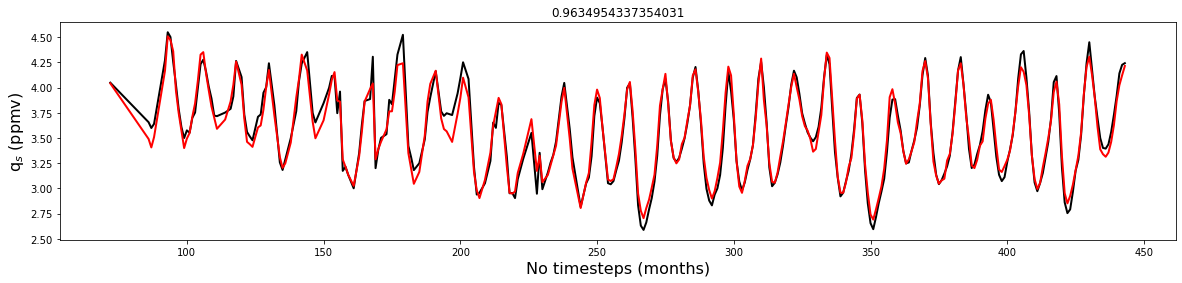

In [32]:
plt.rcParams['figure.figsize'] = [20, 4]
plt.plot(time_swoosh_anomalies,swoosh_tropics_Will_mean[non_nan_indices],color='k',linewidth=2)
plt.plot(time_swoosh_anomalies,era5_predictions_mean,color='r',linewidth=2)
plt.xlabel('No timesteps (months)',size=16)
plt.ylabel('q$_s$ (ppmv)',size=16)
plt.title(r2_score(swoosh_tropics_Will_mean[non_nan_indices],era5_predictions_mean))

0.9611996272680514


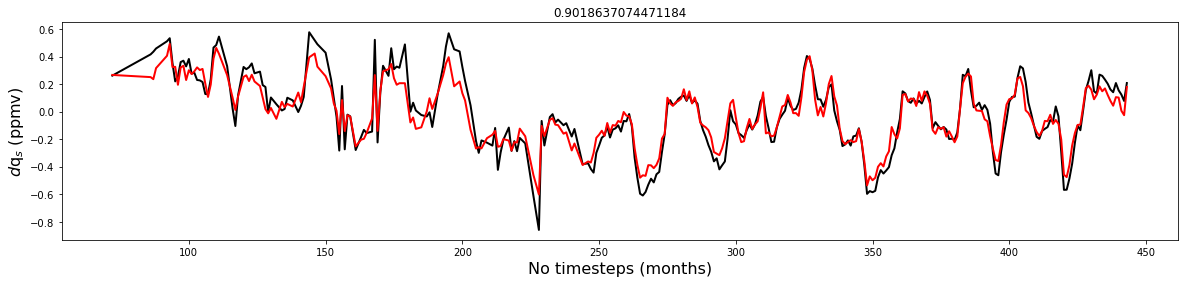

In [39]:
plt.rcParams['figure.figsize'] = [20, 4]
plt.plot(time_swoosh_anomalies,swoosh_anomalies,color='k',linewidth=2)
plt.plot(time_swoosh_anomalies,era5_predictions_mean_anomalies,color='r',linewidth=2)
plt.xlabel('No timesteps (months)',size=16)
plt.ylabel('$d$q$_s$ (ppmv)',size=16)
plt.title(r2_score(swoosh_anomalies,era5_predictions_mean_anomalies))
print(np.corrcoef(swoosh_anomalies[:],era5_predictions_mean_anomalies)[0,1])

In [35]:
### now for MERRA-2
X_lag_hist_merra = np.hstack((X_raw_hist_merra[lag:,:],X_raw_hist_merra[lag-1:-1,:],X_raw_hist_merra[lag-2:-2,:]))
X_lag_hist_merra_Will = X_lag_hist_merra[non_nan_indices_lag[:-12]]
print(X_lag_hist_merra.shape)
scaler_merra = StandardScaler()
x_scaler_merra = scaler_merra.fit(X_lag_hist_merra_Will[:,:])
X_train_norm_merra = x_scaler_merra.transform(X_lag_hist_merra[:,:])
merra_predictions = np.empty((n_swoosh,X_lag_hist_merra.shape[0]))
for i in range(0,n_swoosh):
       merra_predictions[i,:] = np.exp(merra_models['model_'+str(i)].predict(X_train_norm_merra))
merra_predictions_mean = np.mean(merra_predictions[:,:],axis=0)
print(merra_predictions_mean.shape)
merra_predictions_mean_anomalies = np.empty((merra_predictions_mean.shape[0]))
for i in range(0,12):
    merra_predictions_mean_anomalies[i+10::12] = merra_predictions_mean[i+10::12] - h2of_seasonal_cycle[i]
merra_predictions_mean = merra_predictions_mean[non_nan_indices_lag[:-12]]
merra_predictions_mean_anomalies = merra_predictions_mean_anomalies[non_nan_indices_lag[:-12]]

(430, 25920)
(430,)


Text(0.5, 1.0, '0.9603119742487514')

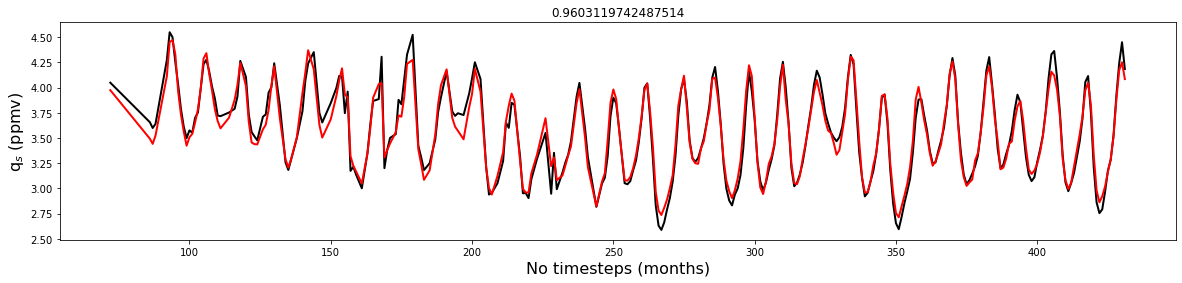

In [38]:
plt.rcParams['figure.figsize'] = [20, 4]
plt.plot(time_swoosh_anomalies[:-12],swoosh_tropics_Will_mean[non_nan_indices][:-12],color='k',linewidth=2)
plt.plot(time_swoosh_anomalies[:-12],merra_predictions_mean,color='r',linewidth=2)
plt.xlabel('No timesteps (months)',size=16)
plt.ylabel('q$_s$ (ppmv)',size=16)
plt.title(r2_score(swoosh_tropics_Will_mean[non_nan_indices][:-12],merra_predictions_mean))

0.9623526048655389


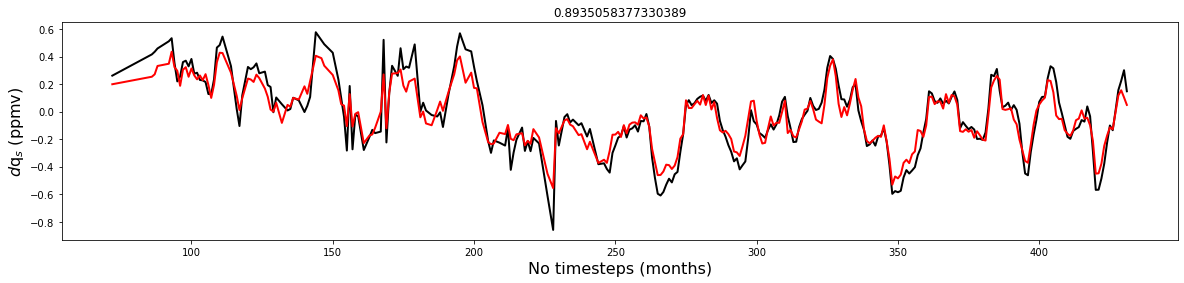

In [40]:
plt.rcParams['figure.figsize'] = [20, 4]
plt.plot(time_swoosh_anomalies[:-12],swoosh_anomalies[:-12],color='k',linewidth=2)
plt.plot(time_swoosh_anomalies[:-12],merra_predictions_mean_anomalies,color='r',linewidth=2)
plt.title(r2_score(swoosh_anomalies[:-12],merra_predictions_mean_anomalies))
plt.xlabel('No timesteps (months)',size=16)
plt.ylabel('$d$q$_s$ (ppmv)',size=16)
print(np.corrcoef(swoosh_anomalies[:-12],merra_predictions_mean_anomalies)[0,1])

In [41]:
### and finally JRA-55
### include lag and scale consistent with the same dataset (zero mean, unit standard deviation)
X_lag_hist_jra = np.hstack((X_raw_hist_jra[lag:,:],X_raw_hist_jra[lag-1:-1,:],X_raw_hist_jra[lag-2:-2,:]))
X_lag_hist_jra_Will = X_lag_hist_jra[non_nan_indices_lag]
print(X_lag_hist_jra.shape)
scaler_jra = StandardScaler()
x_scaler_jra = scaler_jra.fit(X_lag_hist_jra_Will[:,:])
### keep original 444 samples because that's needed later to subtract the seasonal cycle according to SWOOSH
X_train_norm_jra = x_scaler_jra.transform(X_lag_hist_jra[:,:])
jra_predictions = np.empty((n_swoosh,X_lag_hist_jra.shape[0]))
for i in range(0,n_swoosh):
       jra_predictions[i,:] = np.exp(jra_models['model_'+str(i)].predict(X_train_norm_jra))
jra_predictions_mean = np.mean(jra_predictions[:,:],axis=0)
print(jra_predictions_mean.shape)
jra_predictions_mean_anomalies = np.empty((jra_predictions_mean.shape[0]))
for i in range(0,12):
    jra_predictions_mean_anomalies[i+10::12] = jra_predictions_mean[i+10::12] - h2of_seasonal_cycle[i]
jra_predictions_mean = jra_predictions_mean[non_nan_indices_lag]
jra_predictions_mean_anomalies = jra_predictions_mean_anomalies[non_nan_indices_lag]

(442, 25920)
(442,)


Text(0.5, 1.0, '0.9198287527919645')

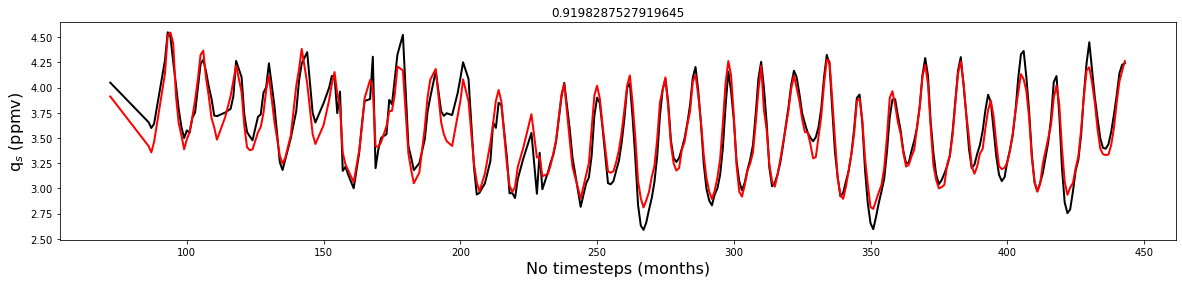

In [43]:
plt.rcParams['figure.figsize'] = [20, 4]
plt.plot(time_swoosh_anomalies,swoosh_tropics_Will_mean[non_nan_indices],color='k',linewidth=2)
plt.plot(time_swoosh_anomalies,jra_predictions_mean,color='r',linewidth=2)
plt.xlabel('No timesteps (months)',size=16)
plt.ylabel('q$_s$ (ppmv)',size=16)
plt.title(r2_score(swoosh_tropics_Will_mean[non_nan_indices],jra_predictions_mean))

0.9049014865977338


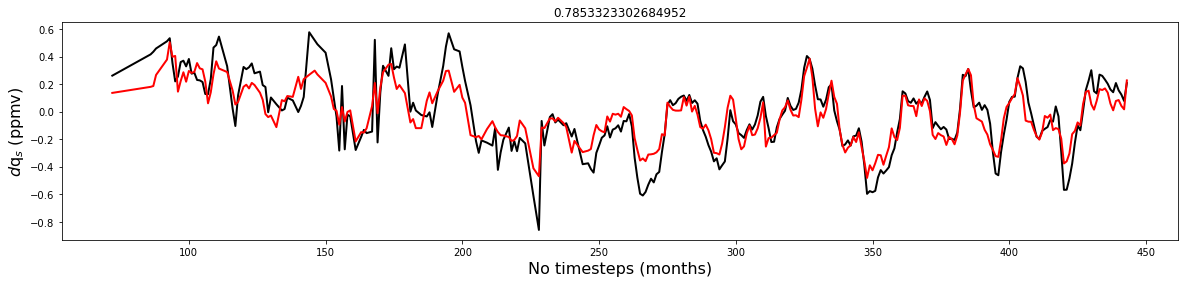

In [44]:
plt.rcParams['figure.figsize'] = [20, 4]
plt.plot(time_swoosh_anomalies,swoosh_anomalies,color='k',linewidth=2)
plt.plot(time_swoosh_anomalies,jra_predictions_mean_anomalies,color='r',linewidth=2)
plt.title(r2_score(swoosh_anomalies,jra_predictions_mean_anomalies))
plt.xlabel('No timesteps (months)',size=16)
plt.ylabel('$d$q$_s$ (ppmv)',size=16)
print(np.corrcoef(swoosh_anomalies[:],jra_predictions_mean_anomalies)[0,1])

In [45]:
### use the 27 selected models
model_list = ['ACCESS1-0', 'ACCESS1-3', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'CAMS-CSM1-0', 'CanESM5', 'CESM2_', 
               'CESM2-WACCM', 'FGOALS-f3-L', 'GFDL-CM3', 'GISS-E2-1-G', 'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 
               'INM-CM5-0', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MPI-ESM-P', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']
print(len(model_list))

27


In [46]:
### define other model sub-lists
model_list_cmip5 = ['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1_', 'bcc-csm1-1-m', 'BNU-ESM', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 'GFDL-CM3', 
               'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC5', 'MIROC-ESM', 'MPI-ESM-LR', 'MPI-ESM-MR', 
                    'MPI-ESM-P', 'MRI-CGCM3', 'NorESM1-M']
model_list_cmip5_1968 = ['MPI-ESM-P']
model_list_cmip5_labels = ['ACCESS1-0', 'ACCESS1-3', 'BCC-CSM1-1', 'BCC-CSM1-1-m', 'BNU-ESM', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 
                           'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-ES', 'INM-CM4', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC5', 'MIROC-ESM', 'MPI-ESM-LR', 'MPI-ESM-MR',
                           'MPI-ESM-P', 'MRI-CGCM3', 'NorESM1-M']

model_list_cmip6 = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR_', 'BCC-ESM1', 'CAMS-CSM1-0', 'CanESM5',
             'CESM2_', 'CESM2-WACCM', 'CNRM-CM6-1','CNRM-ESM2-1', 'E3SM-1-0', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 
             'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
             'MIROC6', 'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'UKESM1-0-LL']
model_list_cmip6_1977 = ['CESM2_', 'E3SM-1-0', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 
             'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0', 'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 
             'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON']
model_list_cmip6_labels = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CanESM5',
             'CESM2', 'CESM2-WACCM', 'CNRM-CM6-1','CNRM-ESM2-1', 'E3SM-1-0', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'FGOALS-g3', 
             'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
             'MIROC6', 'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON', 'UKESM1-0-LL']

In [47]:
nr_models = len(model_list)

In [48]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7.5]

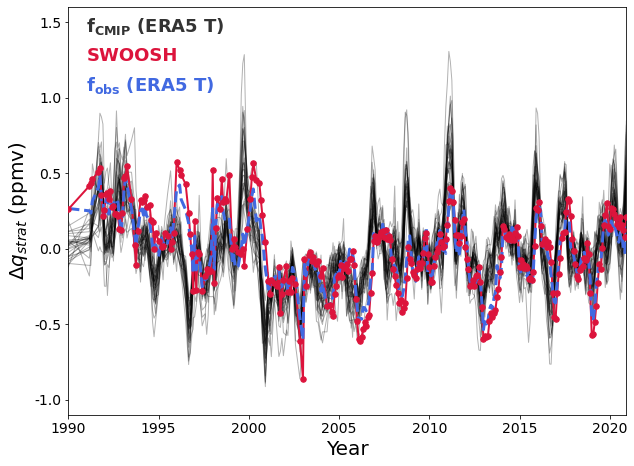

In [49]:
### now combine CMIP functions with reanalysis temperatures
months = np.array(non_nan_indices_lag.flatten())
for modeli in range(0,nr_models):
    regr_model = results_dict[model_list[modeli]][0].best_estimator_
    nt_4xco2 = 1800
    ### recover standard-scaling for CMIP historical
    X_raw_hist = netCDF4.Dataset(glob.glob('./data/cmip/ta/ta*'+model_list[modeli]+'*historical*.nc')[0])['ta'][:nt_train,1:nr_planes-1,la:lb,:]
    X_raw_hist = X_raw_hist.reshape(nt_train,nr_lon*nr_lat*(nr_planes-2))
    X_lag_hist = np.hstack((X_raw_hist[lag:,:],X_raw_hist[lag-1:-1,:],X_raw_hist[lag-2:-2,:]))
    if model_list[modeli] in model_list_cmip5_1968:
### first 192 months can be considered fully covered for the model, similar to the last 192 months in SWOOSH. Critical is the masking covering Pinatubo
        shifted_months = months[:-192]+192
        months_modeli = np.concatenate([np.arange(0,192),shifted_months])
    elif model_list[modeli] in model_list_cmip6_1977:
        shifted_months = months[:-84]+84
        months_modeli = np.concatenate([np.arange(0,84),shifted_months])
    else:
        months_modeli = months
    X_lag_hist_Will = X_lag_hist[months_modeli,:]
    scaler_hist = StandardScaler()
    x_scaler_hist = scaler_hist.fit(X_lag_hist_Will[:,:])    
    ### re-scale so that temperatures fluctuations are seen with the model-consistent amplitude
    X_lag_hist_norm_era5 = X_train_norm_era5*np.sqrt(x_scaler_era5.var_)/np.sqrt(x_scaler_hist.var_)
    y_pred = np.exp(regr_model.predict(X_lag_hist_norm_era5))
    model_cycle = np.empty((12))
    Y_anom = np.empty((y_pred.shape[0]))
    for i in range(0,12):
        model_cycle[i] = np.mean(y_pred[i+12-lag::12])
        Y_anom[i+12-lag::12] = y_pred[i+12-lag::12] - model_cycle[i]
### first 10 months are anyway not in the non-masked months
    Y_anom_masked = Y_anom[non_nan_indices_lag]
    plt.plot(time_swoosh_anomalies,Y_anom_masked,color='k',alpha=0.3,linewidth=1)
plt.plot(time_swoosh_anomalies,swoosh_anomalies,color='crimson',linewidth=2)
plt.scatter(time_swoosh_anomalies,swoosh_anomalies,color='crimson',s=30,zorder=100)
plt.plot(time_swoosh_anomalies,era5_predictions_mean_anomalies,color='royalblue',linewidth=3,linestyle='--')
plt.figtext(0.15,0.835,'$\mathbf{f_{CMIP}}$ (ERA5 T)',color='k',size=18,alpha=0.8,fontweight='bold')
plt.figtext(0.15,0.78,'SWOOSH',color='crimson',size=18,fontweight='bold')
plt.figtext(0.15,0.725,'$\mathbf{f_{obs}}$ (ERA5 T)',color='royalblue',size=18,fontweight='bold')
plt.ylabel('$\Delta q_{strat}$ (ppmv)',size=20)
plt.xlabel('Year',size=20)
plt.xticks([72,132,192,252,312,372,432],['1990','1995','2000','2005','2010','2015','2020'],size=14)
plt.yticks([-1.0,-0.5,0.0,0.5,1.0,1.5],['-1.0','-0.5','0.0','0.5','1.0','1.5'],size=14)
plt.xlim(72,443)
plt.ylim(-1.1,1.6)
plt.show()

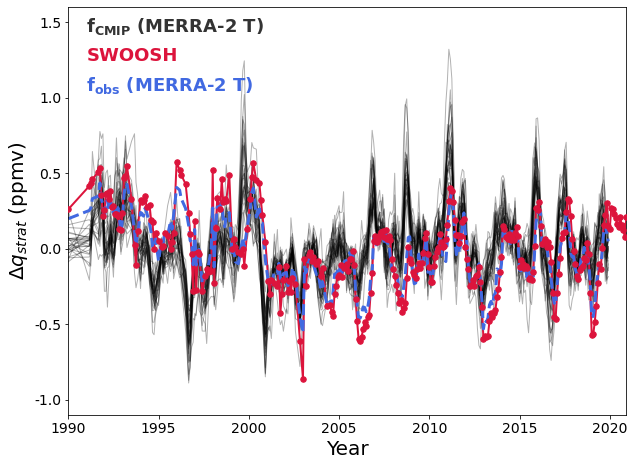

In [51]:
months = np.array(non_nan_indices_lag.flatten())
for modeli in range(0,nr_models):
    regr_model = results_dict[model_list[modeli]][0].best_estimator_
    nt_4xco2 = 1800
    X_raw_hist = netCDF4.Dataset(glob.glob('./data/cmip/ta/ta*'+model_list[modeli]+'*historical*.nc')[0])['ta'][:nt_train,1:nr_planes-1,la:lb,:]
    X_raw_hist = X_raw_hist.reshape(nt_train,nr_lon*nr_lat*(nr_planes-2))
    X_lag_hist = np.hstack((X_raw_hist[lag:,:],X_raw_hist[lag-1:-1,:],X_raw_hist[lag-2:-2,:]))
    if model_list[modeli] in model_list_cmip5_1968:
### first 192 months can be considered fully covered for the model, similar to the last 192 months in SWOOSH. Critical is the masking covering Pinatubo
        shifted_months = months[:-192]+192
        months_modeli = np.concatenate([np.arange(0,192),shifted_months])
    elif model_list[modeli] in model_list_cmip6_1977:
        shifted_months = months[:-84]+84
        months_modeli = np.concatenate([np.arange(0,84),shifted_months])
    else:
        months_modeli = months
    X_lag_hist_Will = X_lag_hist[months_modeli,:]
    scaler_hist = StandardScaler()
    x_scaler_hist = scaler_hist.fit(X_lag_hist_Will[:,:])    
    X_lag_hist_norm_merra = X_train_norm_merra*np.sqrt(x_scaler_merra.var_)/np.sqrt(x_scaler_hist.var_)
    y_pred = np.exp(regr_model.predict(X_lag_hist_norm_merra))
    model_cycle = np.empty((12))
    Y_anom = np.empty((y_pred.shape[0]))
    for i in range(0,12):
        model_cycle[i] = np.mean(y_pred[i+12-lag::12])
        Y_anom[i+12-lag::12] = y_pred[i+12-lag::12] - model_cycle[i]
### first 10 months are anyway not in the non-masked months
    Y_anom_masked = Y_anom[non_nan_indices_lag[:-12]]
    plt.plot(time_swoosh_anomalies[:-12],Y_anom_masked,color='k',alpha=0.3,linewidth=1)
plt.plot(time_swoosh_anomalies,swoosh_anomalies,color='crimson',linewidth=2)
plt.scatter(time_swoosh_anomalies,swoosh_anomalies,color='crimson',s=30,zorder=100)
plt.plot(time_swoosh_anomalies[:-12],merra_predictions_mean_anomalies,color='royalblue',linewidth=3,linestyle='--')
plt.figtext(0.15,0.835,'$\mathbf{f_{CMIP}}$ (MERRA-2 T)',color='k',size=18,alpha=0.8,fontweight='bold')
plt.figtext(0.15,0.78,'SWOOSH',color='crimson',size=18,fontweight='bold')
plt.figtext(0.15,0.725,'$\mathbf{f_{obs}}$ (MERRA-2 T)',color='royalblue',size=18,fontweight='bold')
plt.ylabel('$\Delta q_{strat}$ (ppmv)',size=20)
plt.xlabel('Year',size=20)
plt.xticks([72,132,192,252,312,372,432],['1990','1995','2000','2005','2010','2015','2020'],size=14)
plt.yticks([-1.0,-0.5,0.0,0.5,1.0,1.5],['-1.0','-0.5','0.0','0.5','1.0','1.5'],size=14)
plt.xlim(72,443)
plt.ylim(-1.1,1.6)
plt.show()

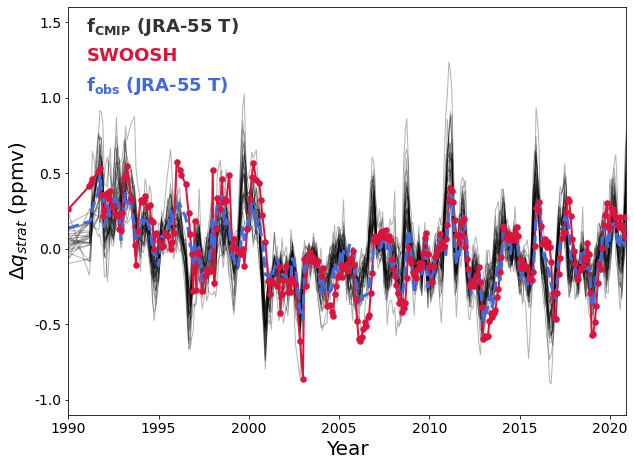

In [52]:
months = np.array(non_nan_indices_lag.flatten())
for modeli in range(0,nr_models):
    regr_model = results_dict[model_list[modeli]][0].best_estimator_
    nt_4xco2 = 1800
    X_raw_hist = netCDF4.Dataset(glob.glob('./data/cmip/ta/ta*'+model_list[modeli]+'*historical*.nc')[0])['ta'][:nt_train,1:nr_planes-1,la:lb,:]
    X_raw_hist = X_raw_hist.reshape(nt_train,nr_lon*nr_lat*(nr_planes-2))
    X_lag_hist = np.hstack((X_raw_hist[lag:,:],X_raw_hist[lag-1:-1,:],X_raw_hist[lag-2:-2,:]))
    if model_list[modeli] in model_list_cmip5_1968:
### first 192 months can be considered fully covered for the model, similar to the last 192 months in SWOOSH. Critical is the masking covering Pinatubo
        shifted_months = months[:-192]+192
        months_modeli = np.concatenate([np.arange(0,192),shifted_months])
    elif model_list[modeli] in model_list_cmip6_1977:
        shifted_months = months[:-84]+84
        months_modeli = np.concatenate([np.arange(0,84),shifted_months])
    else:
        months_modeli = months
    X_lag_hist_Will = X_lag_hist[months_modeli,:]
    scaler_hist = StandardScaler()
    x_scaler_hist = scaler_hist.fit(X_lag_hist_Will[:,:])    
    X_lag_hist_norm_jra = X_train_norm_jra*np.sqrt(x_scaler_jra.var_)/np.sqrt(x_scaler_hist.var_)
    y_pred = np.exp(regr_model.predict(X_lag_hist_norm_jra))
    model_cycle = np.empty((12))
    Y_anom = np.empty((y_pred.shape[0]))
    for i in range(0,12):
        model_cycle[i] = np.mean(y_pred[i+12-lag::12])
        Y_anom[i+12-lag::12] = y_pred[i+12-lag::12] - model_cycle[i]
### first 10 months are anyway not in the non-masked months
    Y_anom_masked = Y_anom[non_nan_indices_lag]
    plt.plot(time_swoosh_anomalies,Y_anom_masked,color='k',alpha=0.3,linewidth=1)
plt.plot(time_swoosh_anomalies,swoosh_anomalies,color='crimson',linewidth=2)
plt.scatter(time_swoosh_anomalies,swoosh_anomalies,color='crimson',s=30,zorder=100)
plt.plot(time_swoosh_anomalies,jra_predictions_mean_anomalies,color='royalblue',linewidth=3,linestyle='--')
plt.figtext(0.15,0.835,'$\mathbf{f_{CMIP}}$ (JRA-55 T)',color='k',size=18,alpha=0.8,fontweight='bold')
plt.figtext(0.15,0.78,'SWOOSH',color='crimson',size=18,fontweight='bold')
plt.figtext(0.15,0.725,'$\mathbf{f_{obs}}$ (JRA-55 T)',color='royalblue',size=18,fontweight='bold')
plt.ylabel('$\Delta q_{strat}$ (ppmv)',size=20)
plt.xlabel('Year',size=20)
plt.xticks([72,132,192,252,312,372,432],['1990','1995','2000','2005','2010','2015','2020'],size=14)
plt.yticks([-1.0,-0.5,0.0,0.5,1.0,1.5],['-1.0','-0.5','0.0','0.5','1.0','1.5'],size=14)
plt.xlim(72,443)
plt.ylim(-1.1,1.6)
plt.show()